## PyTorch Going Modular

In this Notebook, we are going to build useful Python scripts for dataloading, training, evaluation etc.

We are going to build the following files:
* `data_setup.py` - a file to prepare and download data if needed.
* `engine.py` - a file containing various training functions.
* `model_builder.py` or `model.py` - a file to create a PyTorch model.
* `train.py` - a file to leverage all other files and train a target PyTorch model.
* `utils.py` - a file dedicated to helpful utility functions.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

## Get Data

* We are going to download data from Daniel's github repo and unzip the file

In [2]:
!mkdir going_modular

In [3]:
%%writefile going_modular/get_data.py
"""
Contains Functions to download a dataset from Web URL
"""

import os
import requests
import zipfile
from pathlib import Path

def download_data(web_url: str):
    '''
    Downloads data in the form of .zip file from any web url

    Args:
      web_url: str - URL having zip file

    Example:
    download_data('YOUR_URL_PATH')
    '''
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / "data"

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"{image_path} directory exists.")
        return None
    else:
        print(f"Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "data.zip", "wb") as f:
        request = requests.get(web_url)
        print("Downloading data......")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "data.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove zip file
    os.remove(data_path / "data.zip")

Writing going_modular/get_data.py


In [4]:
from going_modular import get_data
get_data.download_data('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')

Did not find data/data directory, creating one...
Unzipping pizza, steak, sushi data...


## Create a Script: Converting data into ImageFolder (PyTorch datasets) then to PyTorch DataLoaders

In [5]:
%%writefile going_modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""

import torch
import torchvision
import os

BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

def create_dataloaders(train_dir: str,
                       test_dir: str,
                       train_transform: torchvision.transforms.Compose,
                       test_transform: torchvision.transforms.Compose,
                       batch_size: int = BATCH_SIZE,
                       num_workers: int = NUM_WORKERS):
  '''This Function helps in loading our dataset and finally converting them into Data Loaders for our model to train

  Args:
    train_dir: str - Train data Directory Path.
    test_dir: str - Test data Directory Path.
    train_transform: torchvision.transforms.Compose - torchvision transforms to perform on training data.
    train_transform: torchvision.transforms.Compose - torchvision transforms to perform on testing data.
    batch_size: int - Number of samples per batch in each of the DataLoaders.
    num_workers: int - An integer for number of workers per DataLoader.

  Returns: (train_dataloader, test_dataloader, class_names)
    train_dataloader: torch.utils.data.DataLoader - Train data converted to iterable batches.
    test_dataloader: torch.utils.data.DataLoader - Test data converted to iterable batches.
    class_names: list - Class Names found while loading Data

  Example:
  train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir="path/to/train_data/",
    test_dir="path/to/test_data/",
    train_transform=train_data_transform_pipeline,
    test_transform=test_data_transform_pipeline,
    batch_size=32,
    num_workers=16
  )

  '''

  # Converting our data into PyTorch ImageFolder Datasets
  train_data = torchvision.datasets.ImageFolder(
      root=train_dir,
      transform=train_transform
  )

  test_data = torchvision.datasets.ImageFolder(
      root=test_dir,
      transform=test_transform
  )

  print(f'Found {len(train_data)} images in train directory')
  print(f'Found {len(test_data)} images in test directory')

  class_names = train_data.classes

  # Converting our PyTorch ImageFolder Datasets into DataLoaders
  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_data,
      shuffle=True,
      batch_size=batch_size,
      num_workers=num_workers
  )

  test_dataloader = torch.utils.data.DataLoader(
      dataset=test_data,
      shuffle=False,
      batch_size=batch_size,
      num_workers=num_workers
  )

  print('---------------')
  print(f'Train Data has {len(train_dataloader)} batches of size {train_dataloader.batch_size}')
  print(f'Test Data has {len(test_dataloader)} batches of size {test_dataloader.batch_size}')

  return train_dataloader, test_dataloader, class_names

Writing going_modular/data_setup.py


### Let's see how we can use this function

In [6]:
train_path='/content/data/data/train'
test_path='/content/data/data/test'

In [7]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [8]:
import os
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

In [9]:
from going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_path,
    test_dir=test_path,
    train_transform=simple_transform,
    test_transform=simple_transform,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

Found 225 images in train directory
Found 75 images in test directory
---------------
Train Data has 8 batches of size 32
Test Data has 3 batches of size 32


## Create a Script: Constuct a Model

In [10]:
%%writefile going_modular/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch
from torch import nn

class TinyVGG(nn.Module):
  """Creates the TinyVGG architecture.

  Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
  See the original architecture here: https://poloclub.github.io/cnn-explainer/

  Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*53*53, out_features=128),
          nn.ReLU(),
          nn.Linear(in_features=128, out_features=64),
          nn.ReLU(),
          nn.Linear(in_features=64, out_features=32),
          nn.ReLU(),
          nn.Linear(in_features=32, out_features=output_shape)
      )

  def forward(self, x: torch.Tensor):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      x = self.classifier(x)
      return x
      # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

Writing going_modular/model_builder.py


In [11]:
from going_modular import model_builder

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=16,
    output_shape=len(class_names)
).to(device)

model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=44944, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [12]:
# Dummy pass
img_batch, label_batch = next(iter(train_dataloader))

model.eval()
with torch.inference_mode():
  y_preds = torch.argmax(torch.softmax(model(img_batch[0].unsqueeze(dim=0).to(device)), dim=1), dim=1)
print(f'Prediction: {y_preds}')
print(f'Truth Label: {label_batch[0]}')

Prediction: tensor([1], device='cuda:0')
Truth Label: 2


## Create a Script: Model Train and Test steps

In [13]:
%%writefile going_modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.5f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.5f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

Writing going_modular/engine.py


In [14]:
from going_modular import engine
# engine.train()

## Create a Script: Saving and Loading our model

In [15]:
%%writefile going_modular/utils.py
"""
Contains functions for Saving and Loading a Model
"""

import torch

def save_model(model: torch.nn.Module,
               path: str):
  '''Saves model's state dict to the path mentioned

  Args:
    model: torch.nn.Module - PyTorch model to save.
    path: str - File path for saving model.
  '''

  if not ".pt" in path or ".pth" in path:
    print(f'Please mention the file extension: ".pt" or ".pth" in path')

  else:
    torch.save(obj=model.state_dict(), f=path)
  print(f'Model saved to {path}')



def load_model(constructed_model: torch.nn.Module, path: str):
  '''Loades a model's state dict into a existing model of the same architecture

  Args:
    constructed_model: torch.nn.Module - Pre-built model of the same architecture of saved model.
    path: str - Saved model's path.
  '''

  if not ".pt" in path or ".pth" in path:
    print(f'Please mention the file extension: ".pt" or ".pth" in path')
    return None
  else:
    constructed_model.load_state_dict(torch.load(f=path))
    return constructed_model

Writing going_modular/utils.py


## Setting up a training Script to wrap everything under a function

In [16]:
%%writefile going_modular/train_model.py

from torchvision.transforms.autoaugment import TrivialAugmentWide
import os
import data_setup, model_builder, engine, utils

import torch
from torchvision import transforms

import argparse
# Make Arguments
parser = argparse.ArgumentParser(
    prog='Training TinyVGG model Script',
    description='Trains a model, based on different Hyperparameter settings'
)

parser.add_argument('--epochs', type=int, help='Number of times model should look over data')
parser.add_argument('--batch_size', type=int, help='Batch Size for DataLoaders')
parser.add_argument('--hidden_units', type=int, help='Hidden Units for model')
parser.add_argument('--lr', type=float, help='Learning rate for model')
parser.add_argument('--train_path', type=str, help='Train Data path')
parser.add_argument('--test_path', type=str, help='Test Data Path')
args = parser.parse_args()

# Setup hyperparameters
NUM_EPOCHS = args.epochs
BATCH_SIZE = args.batch_size
HIDDEN_UNITS = args.hidden_units
LEARNING_RATE = args.lr
TRAIN_PATH = args.train_path
TEST_PATH = args.test_path

# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting up Data Transformation Pipeline
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.65),
    transforms.TrivialAugmentWide(num_magnitude_bins=25),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

# Set up our data into dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=TRAIN_PATH,
    test_dir=TEST_PATH,
    train_transform=train_transforms,
    test_transform=test_transforms,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count()
)

# Building our model
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# Setup loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=LEARNING_RATE
)

# Training our model
engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    device=device
)

# Saving our model
utils.save_model(model=model, path='modular_scripts_model.pt')

Writing going_modular/train_model.py


## Training Our PyTorch model using all Modular Scripts in one Bash Command line script

In [17]:
!python going_modular/train_model.py --epochs 5 --batch_size 32 --hidden_units 16 --lr 0.001 --train_path '/content/data/data/train' --test_path '/content/data/data/test'

Found 225 images in train directory
Found 75 images in test directory
---------------
Train Data has 8 batches of size 32
Test Data has 3 batches of size 32
  0% 0/5 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.09166 | train_acc: 0.4492 | test_loss: 1.1153 | test_acc: 0.26042
 20% 1/5 [00:04<00:19,  4.78s/it]Epoch: 2 | train_loss: 1.09835 | train_acc: 0.4297 | test_loss: 1.1447 | test_acc: 0.19792
 40% 2/5 [00:06<00:09,  3.10s/it]Epoch: 3 | train_loss: 1.11745 | train_acc: 0.2930 | test_loss: 1.1206 | test_acc: 0.19792
 60% 3/5 [00:08<00:04,  2.37s/it]Epoch: 4 | train_loss: 1.07393 | train_acc: 0.4336 | test_loss: 1.0958 | test_acc: 0.30208
 80% 4/5 [00:09<00:02,  2.01s/it]Epoch: 5 | train_loss: 1.03421 | train_acc: 0.5117 | test_loss: 1.0624 | test_acc: 0.33333
100% 5/5 [00:11<00:00,  2.22s/it]
Model saved to modular_scripts_model.pt


## Create a Script for prediction

In [18]:
%%writefile going_modular/predict.py
"""
contains functions to load a model and then make predictions on it
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import model_builder
import ast

import argparse
parser = argparse.ArgumentParser(
    prog='Predicting using  TinyVGG model in Script',
    description='Predicts on Image using TinyVGG model'
)

parser.add_argument('--model_saved_path', type=str, help='Path at which PyTorch model is saved')
parser.add_argument('--img_path', type=str, help='Path of Image')
parser.add_argument('--img_shape', type=int, help='shape of Image needed by PyTorch model')
parser.add_argument('--class_names', type=str, help='Class names inside a string with 1 space between each')
args = parser.parse_args()

model_path = args.model_saved_path
img_path = args.img_path
img_size = args.img_shape
class_names = ast.literal_eval(args.class_names)

device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=16,
    output_shape=len(class_names)
).to(device)

loaded_model.load_state_dict(torch.load(model_path))

# set up image resizing transformation
custom_image_transform = transforms.Compose([
  transforms.Resize(size=(img_size, img_size), antialias=True)
])

img = torchvision.io.read_image(img_path).type(torch.float) / 255.
input_tensor = custom_image_transform(img).unsqueeze(dim=0).to(device)

loaded_model.eval()
with torch.inference_mode():
  y_logits = loaded_model(input_tensor)
y_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_probs, dim=1)

plt.imshow(input_tensor.cpu().squeeze().permute([1, 2, 0]))
plt.title(f'Class: {class_names[y_preds.item()]} \nProbs: {torch.max(y_probs).item():.3f}%')
plt.axis('off')
plt.show()

Writing going_modular/predict.py


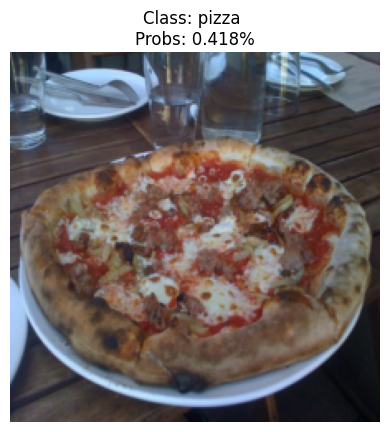

<Figure size 640x480 with 0 Axes>

In [23]:
%run going_modular/predict.py --model_saved_path '/content/modular_scripts_model.pt' --img_path '/content/data/data/train/pizza/5764.jpg' --img_shape 224 --class_names "['pizza', 'steak', 'sushi']"

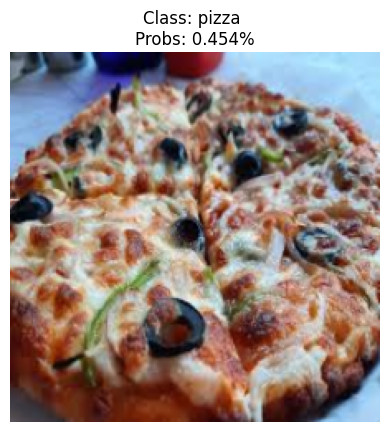

<Figure size 640x480 with 0 Axes>

In [26]:
%run going_modular/predict.py --model_saved_path '/content/modular_scripts_model.pt' --img_path '/content/pizza_img.jpeg' --img_shape 224 --class_names "['pizza', 'steak', 'sushi']"

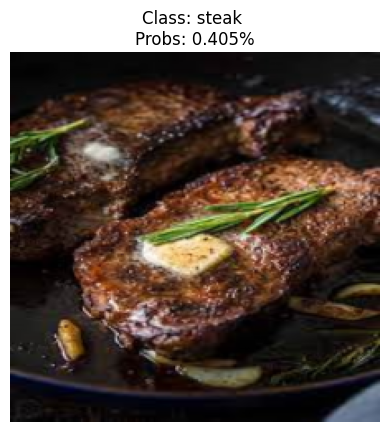

<Figure size 640x480 with 0 Axes>

In [27]:
%run going_modular/predict.py --model_saved_path '/content/modular_scripts_model.pt' --img_path '/content/steak-img.jpeg' --img_shape 224 --class_names "['pizza', 'steak', 'sushi']"

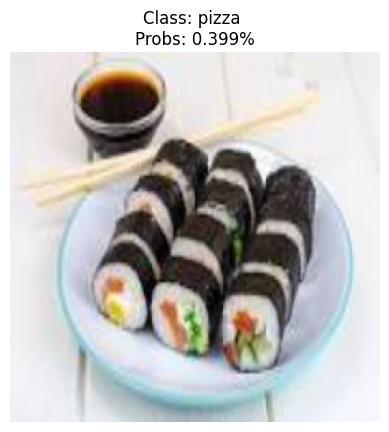

<Figure size 640x480 with 0 Axes>

In [28]:
%run going_modular/predict.py --model_saved_path '/content/modular_scripts_model.pt' --img_path '/content/sushi-img.jpeg' --img_shape 224 --class_names "['pizza', 'steak', 'sushi']"